In [1]:
import sys
import os
import numpy as np
from mxnet import nd, autograd as ag, gluon
from dataloader import DataLoader

# Data

In [2]:
dl = DataLoader(os.environ["HOME"] + '/.datasets/Han.Xiao/fashion-mnist/')
train_img,train_labels = dl.get_data(kind='train')
test_img,test_labels = dl.get_data(kind='t10k')

train_img_nd = nd.array(train_img).astype(np.float32)/255
train_lab_nd = nd.array(train_labels).astype(np.float32)
test_img_nd = nd.array(test_img).astype(np.float32)/255
test_lab_nd = nd.array(test_labels).astype(np.float32)

def data_iter(batch_size=100, kind='train'):
    if kind != 'train':
        idx = list(range(len(test_labels)))
        for i in range(0,len(test_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(test_labels))])
            yield nd.take(test_img_nd,j), nd.take(test_lab_nd,j)
    else:
        idx = list(range(len(train_labels)))
        for i in range(0,len(train_labels), batch_size):
            j = nd.array(idx[i:min(i+batch_size,len(train_labels))])
            yield nd.take(train_img_nd,j), nd.take(train_lab_nd,j)

# Model

In [3]:
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(256, activation="relu"))
    net.add(gluon.nn.Dropout(0.5))
    net.add(gluon.nn.Dense(10))

net.initialize()

softmax_cross_entropy = gluon.loss.SoftmaxCrossEntropyLoss()

weight_decay = 5 # w = w - lr*grad - wd * w
trainer = gluon.Trainer(net.collect_params(), 
                        'sgd', 
                        {'learning_rate': 0.5})

# Train

In [4]:
def accuracy(yhat,y):
    return nd.mean(yhat.argmax(axis=1)==y).asscalar()

In [5]:
batch_size = 100
epochs = 100

for epoch in range(epochs):
    train_loss = 0.
    train_accu = 0.
    for data, label in data_iter(batch_size=batch_size):
        with ag.record():
            output = net(data)
            loss = softmax_cross_entropy(output, label)
        loss.backward()
        trainer.step(batch_size)

        train_loss += nd.mean(loss).asscalar()
        train_accu += accuracy(output,label)

    print("epoch:%d; loss:%f; accu:%f" % (epoch, 
                    train_loss/len(train_labels)*batch_size,
                    train_accu/len(train_labels)*batch_size))

epoch:0; loss:0.735848; accu:0.727350
epoch:1; loss:0.535888; accu:0.804167
epoch:2; loss:0.491346; accu:0.821050
epoch:3; loss:0.461040; accu:0.830733
epoch:4; loss:0.441905; accu:0.839683
epoch:5; loss:0.429350; accu:0.845250
epoch:6; loss:0.412446; accu:0.849067
epoch:7; loss:0.405068; accu:0.851500
epoch:8; loss:0.394750; accu:0.856633
epoch:9; loss:0.393314; accu:0.856833
epoch:10; loss:0.385484; accu:0.858483
epoch:11; loss:0.377570; accu:0.861233
epoch:12; loss:0.371683; accu:0.864117
epoch:13; loss:0.367285; accu:0.865333
epoch:14; loss:0.368267; accu:0.864517
epoch:15; loss:0.357330; accu:0.869417
epoch:16; loss:0.352045; accu:0.869650
epoch:17; loss:0.351982; accu:0.872217
epoch:18; loss:0.350888; accu:0.873500
epoch:19; loss:0.344736; accu:0.873783
epoch:20; loss:0.340892; accu:0.875050
epoch:21; loss:0.336005; accu:0.875717
epoch:22; loss:0.330514; accu:0.876867
epoch:23; loss:0.329705; accu:0.879467
epoch:24; loss:0.327692; accu:0.879117
epoch:25; loss:0.327439; accu:0.878

# Test

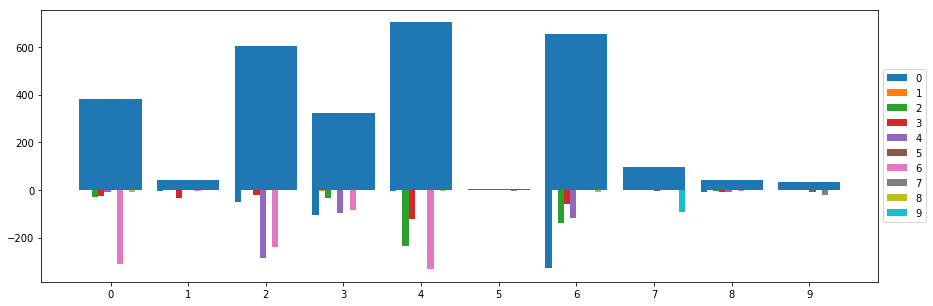

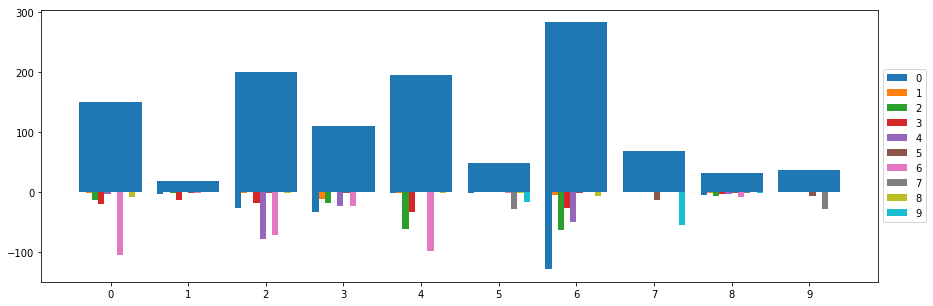

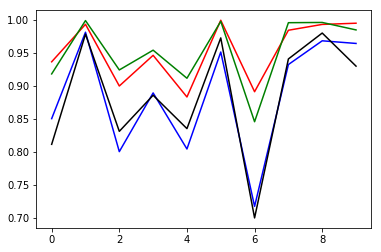

In [6]:
from matplotlib import pyplot as plt
from statiser import Statistics
train_statistics = Statistics(net(train_img_nd).argmax(axis=1).asnumpy(), 
                              train_lab_nd.asnumpy())
test_statistics = Statistics(net(test_img_nd).argmax(axis=1).asnumpy(), 
                             test_lab_nd.asnumpy())
train_statistics.show()
test_statistics.show()
plt.plot(range(10),train_statistics.Recall(),'r')
plt.plot(range(10),train_statistics.Precision(),'g')
plt.plot(range(10),test_statistics.Recall(),'b')
plt.plot(range(10),test_statistics.Precision(),'k')
plt.show()